# Predicting Hand Drawn Captcha

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import Model

from PIL import Image
import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

In [4]:
from emnist import list_datasets
from emnist import extract_training_samples, extract_test_samples

In [5]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

## Load Data

In [6]:
len(os.listdir('../data/drawn/'))

1013366

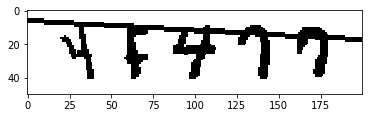

In [7]:
img=cv2.imread('../data/drawn/4f477.png',cv2.IMREAD_UNCHANGED)
plt.imshow(img, cmap=plt.cm.binary)

In [8]:
chars = '0123456789' + string.ascii_lowercase
num_chars = len(chars)

def data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png':
            pass
        else:
            print(name)
            
def mix_img(img, fill_val = 0):
    # random rotate value
    ang_list = [-5,-4,-3,-2,-1,0,0,0,0,0,1,2,3,4,5]
    ang = random.choice(ang_list)
    # rotate image
    im = Image.fromarray(img)
    img = np.asarray(im.rotate(ang))
    
    return img

def load_drawn_data(from_src=False):
    if from_src:
        path = '../data/drawn/'
    else:
        path = 'data/drawn/'
        
    leng = 750000#len(os.listdir(path))
        
    X = np.zeros((leng, 50, 200, 1)) 
    y = np.zeros((5, leng, num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        
        if i == leng:
            break
            
        img_path = path + name
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, np.array(labels)

In [9]:
data_check(from_src=True)

In [ ]:
nX, ny, nlabels = load_drawn_data(from_src=True)

In [ ]:
nX.shape, ny.shape, nlabels.shape

## Build Model

In [12]:
# Model Outline
input_shape = (50, 200, 1)
i = [32,64,32,32,5,16]

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(i[0], (i[4], i[4]), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(i[1], (i[4], i[4]), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(i[2], (i[4], i[4]), padding='same', activation='relu')(mp2)
mp3 = MaxPooling2D(padding='same')(cn3)   

cn4 = Conv2D(i[3], (i[4], i[4]), padding='same', activation='relu')(mp3)
bn = BatchNormalization()(cn4)
mp4 = MaxPooling2D(padding='same')(bn) 

cn5 = Conv2D(i[5], (i[4], i[4]), padding='same', activation='relu')(mp4)
mp5 = MaxPooling2D(padding='same')(cn5)

# Flatten and Dense layers
flat = Flatten()(mp5)
output = []
for _ in range(5):
    dens1 = Dense(128, activation='relu')(flat)
    drop = Dropout(0.5)(dens1)
    result = Dense(num_chars, activation='sigmoid')(drop)

    output.append(result)

In [13]:
# Compile model
model = Model(imgm, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [14]:
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 32)  832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 64)  51264       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [15]:
history = model.fit(nX, [ny[0], ny[1], ny[2], ny[3], ny[4]],
                 batch_size=256, epochs=10, verbose=2, validation_split=0.2)

Train on 600000 samples, validate on 150000 samples
Epoch 1/10
600000/600000 - 409s - loss: 3.5248 - dense_1_loss: 0.6918 - dense_3_loss: 0.7228 - dense_5_loss: 0.7219 - dense_7_loss: 0.7235 - dense_9_loss: 0.6646 - dense_1_accuracy: 0.7955 - dense_3_accuracy: 0.7864 - dense_5_accuracy: 0.7862 - dense_7_accuracy: 0.7870 - dense_9_accuracy: 0.8035 - val_loss: 1.3747 - val_dense_1_loss: 0.2694 - val_dense_3_loss: 0.2810 - val_dense_5_loss: 0.2786 - val_dense_7_loss: 0.2784 - val_dense_9_loss: 0.2672 - val_dense_1_accuracy: 0.9103 - val_dense_3_accuracy: 0.9060 - val_dense_5_accuracy: 0.9069 - val_dense_7_accuracy: 0.9072 - val_dense_9_accuracy: 0.9087
Epoch 2/10
600000/600000 - 395s - loss: 1.5439 - dense_1_loss: 0.3018 - dense_3_loss: 0.3167 - dense_5_loss: 0.3115 - dense_7_loss: 0.3163 - dense_9_loss: 0.2976 - dense_1_accuracy: 0.9033 - dense_3_accuracy: 0.8996 - dense_5_accuracy: 0.9005 - dense_7_accuracy: 0.8997 - dense_9_accuracy: 0.9046 - val_loss: 1.2319 - val_dense_1_loss: 0.2440

In [16]:
acc, loss = [], []
for i, l in enumerate(history.history.values()):
    if i >= 17:
        acc.append(l)
    elif i >= 12:
        loss.append(l)
        #print(i)

In [17]:
[max(i).round(2) for i in acc]

[0.93, 0.93, 0.93, 0.93, 0.93]

32/64/32/16 (7)
- dense 64: [0.9, 0.89, 0.89, 0.89, 0.9]
- dense 128: [0.91, 0.9, 0.9, 0.9, 0.9]
- bn/dense 128: [0.91, 0.9, 0.9, 0.9, 0.9]


''

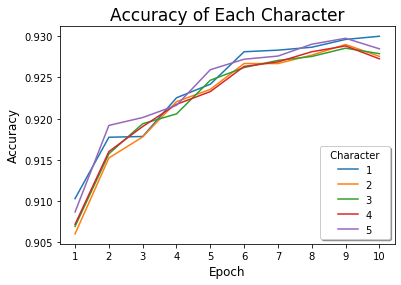

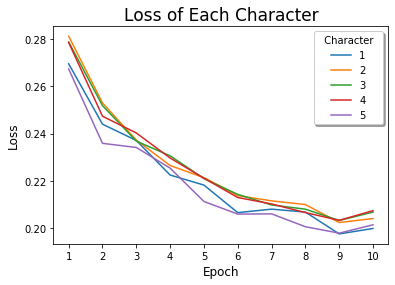

In [24]:
# Get number of epochs
epochs = range(len(acc[0]))

# Plot validation accuracy per epoch
for i in acc:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='lower right', title='  Character  ', shadow=True)
plt.title('Accuracy of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Accuracy', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_acc_.png')
plt.figure()

# Plot training and validation loss per epoch
for i in loss:
    plt.plot(epochs, i)
plt.legend(['1','2','3','4','5'], loc='upper right', title='  Character  ', shadow=True)
plt.title('Loss of Each Character', fontdict={'size':'17'})
plt.xlabel('Epoch', fontdict={'size':'12'})
plt.ylabel('Loss', fontdict={'size':'12'})
plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10])

#plt.savefig('../images/drawn_cap_loss_.png')
;

In [25]:
def predict_one(img, true):
    # Find prediction for each character output
    onehotpred = np.array(model.predict(img.reshape(1,50,200,1))).reshape(5,36)    
    pred = ''
    
    # Concatenate each character prediction
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

In [27]:
img=cv2.imread('../data/drawn/34f3e.png',cv2.IMREAD_UNCHANGED)
img = img / 255.0
img = img.reshape(50, 200, 1)
predict_one(img, '34f3e')

('34f3e', '34f3e')

In [28]:
#model.save('../models/final_draw_model.h5')